# Convert a PyTorch Classification Model to ONNX and OpenVINO™ IR

This short tutorial demonstrates step-by-step instruction how to convert Pytorch classification model to OpenVINO IR. The notebook shows how to convert and optimize the [ResNet50 model](https://pytorch.org/vision/stable/models/resnet50.html) and then classify an image with OpenVINO Runtime as example, but similar steps are applicable to other classification models (e.g. from torchvision or timm models zoo) trained on custom dataset.

This tutorial consists of the following steps:
- Prepare PyTorch model
- Download and prepare dataset
- Validate original model
- Convert PyTorch model to ONNX
- Convert ONNX model to OpenVINO IR
- Validate converted model
- Prepare and run optimization pipeline
- Compare accuracy of the FP32 and quantized models.
- Compare performance of the FP32 and quantized models.

## Get Pytorch model

Generally, PyTorch model represents instance of torch.nn.Module class, iniatilized by state dictionary with model weights.
We will use ResNet50 model pretrained on CIFAR10 dataset, which available in this [repo](https://github.com/huyvnphan/PyTorch_CIFAR10/).
Typical steps for getting pretrained model:
1. Create instance of model class
2. Load checkpoint state dict, which contains pretrained model weights
3. Turn model to evaluation for switching some operations to inference mode

### Prerequisits

In [1]:
# clone model repo and change working directory
!git clone https://github.com/huyvnphan/PyTorch_CIFAR10.git
%cd PyTorch_CIFAR10

Cloning into 'PyTorch_CIFAR10'...
remote: Enumerating objects: 690, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 690 (delta 52), reused 36 (delta 36), pack-reused 624
Receiving objects: 100% (690/690), 6.58 MiB | 4.03 MiB/s, done.
Resolving deltas: 100% (269/269), done.
/home/ea/work/openvino_notebooks/notebooks/102-pytorch-onnx-to-openvino/1020-vision-classification/PyTorch_CIFAR10


In [2]:
import sys
from pathlib import Path
from zipfile import ZipFile

sys.path.append("../../../utils")
from notebook_utils import download_file

# create directories for model and data storing, download model weights
MODEL_LINK = "https://rutgers.box.com/shared/static/gkw08ecs797j2et1ksmbg1w5t3idf5r5.zip"
DATA_DIR = Path("data/")
MODEL_DIR = Path("model/")
FILE_NAME = 'state_dicts.zip'
MODEL_DIR.mkdir(exist_ok=True)
DATA_DIR.mkdir(exist_ok=True)

download_file(MODEL_LINK, directory=MODEL_DIR, show_progress=True)
# model weights stored in zip archive, we need unzeep it before usage
with ZipFile(f"{MODEL_DIR}/{FILE_NAME}", "r") as zip_ref:
    zip_ref.extractall(MODEL_DIR)


model/state_dicts.zip:   0%|          | 0.00/933M [00:00<?, ?B/s]

### Instantiate model

`resnet50` function returns instance of our model class. It has additional parameter `pretrained` for automatic loading pretrained weights, but for making tutorial more useful and applicable for custom trained models, we postpone model weights loading.

In [3]:

from cifar10_models.resnet import resnet50
# call function for creating model
pt_model = resnet50(pretrained=False)

### Load model weights
We downloaded model chckpoint to `model\state_dicts\resnet50.pt`, now we should load it to the model using standart pytorch api 

In [4]:
import torch
# load model checkpoint
# we use map_location='cpu' parameter for guarantee that we can load it on our device, even if it was saved onm another device type
pt_model.load_state_dict(torch.load('model/state_dicts/resnet50.pt', map_location='cpu'))

<All keys matched successfully>

In [5]:
# switch model to evaluation mode
pt_model.eval()
pass

## Verify loaded model

Now, when we created model, we can verify its work

### Prepare dataset and preprocessing

This model pretrained on [CIFAR10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10) dataset, we will use torchvision helper for this dataset.
According [model usage instruction](https://github.com/huyvnphan/PyTorch_CIFAR10#how-to-use-pretrained-models) model was trained on normalized images with mean [0.4914, 0.4822, 0.4465] and std [0.2471, 0.2435, 0.2616], we will use such preprocessing parameters for pretrained model validation.

In [6]:
import torchvision
# define preprocessing steps for model
mean = [0.4914, 0.4822, 0.4465]
std = [0.2471, 0.2435, 0.2616]
transform = torchvision.transforms.Compose(
    [
        # ToTensor converts images in U8 [0, 255] data range to float tensor in [0, 1] range
        torchvision.transforms.ToTensor(),
        # normalize image using mean and std
        torchvision.transforms.Normalize(
            mean=mean, 
            std=std
        )
    ]
)


# define dataset for validation
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# create dataloader
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=0)

# labels used in dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


### Check model inference result for single image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


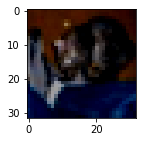

Annotation label: cat
Predicted label: cat


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = (npimg + mean) * std    # unnormalize
    plt.figure(figsize=(2,2))
    plt.imshow(npimg)
    plt.show()


# get image from dataset
data = next(iter(testloader))
image, label = data

# make prediction

predicted_scores = pt_model(image)
predicted_label = torch.argmax(predicted_scores)
imshow(image[0])
print(f'Annotation label: {classes[label[0].item()]}')
print(f'Predicted label: {classes[predicted_label.item()]}') 


### Define Accuracy metric

Before starting converting model to OpenVINO, let's verify its accuracy. We will use [accuracy](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html#accuracy) metric from [torchmetrics](https://torchmetrics.readthedocs.io/en/latest/) for that

In [10]:
from torchmetrics import Accuracy
from tqdm.notebook import tqdm
accuracy_metric = Accuracy()

for (img, lbl) in tqdm(testloader):
    prediction_scores = pt_model(img)
    accuracy_metric.update(torch.argmax(prediction_scores, dim=1), lbl)
print(f'Accuracy model on {len(testloader)} images {accuracy_metric.compute()}')

/home/ea/work/notebooks_env/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/home/ea/work/notebooks_env/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:24: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
/home/ea/work/notebooks_env/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
/home/ea/work/notebooks_env/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:28: DeprecationWarning: HAMMING is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.HAMMING instead.
  if hasattr(pil_imag

  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy model on 10000 images 0.9365000128746033


## Export model to ONNX\* format

OpenVINO supports PyTorch\* through export to the ONNX\* format. We will use `torch.onnx.export` function for obtaining ONNX, 
you can find more info about it in [PyTorch documentation](https://pytorch.org/docs/stable/onnx.html). 
We need provide model object, input data for model tracing (we will use the same image, which we use during model inference validation) 
and path for model saving. 
Optioanally, we can provide target onnx opset for conversion and other parameters specified in documentation (e.g. input and output names or dynamic shapes)

In [11]:
import onnx
torch.onnx.export(pt_model, image, 'model/resnet50.onnx', opset_version=11, input_names=['input'], output_names=['output'])


### Verify ONNX file correctness

The code below demonstrates how to check that ONNX graph has correct representation

In [12]:
# Load the ONNX model
onnx_model = onnx.load("model/resnet50.onnx")

# Check that the model is well formed
onnx.checker.check_model(onnx_model)

## Convert ONNX Model to OpenVINO Intermideate Representation
While ONNX models are directly supported by OpenVINO™, it can be useful to convert them to IR format to take advantage of OpenVINO optimization tools and features.
`mo.convert` function can be used for converting model using OpenVINO Model Optimizer capabilities. 
It returns of instance OpenVINO Model class, which is ready to use in python interface and can be serialized to IR for future execution.

In [13]:
from openvino.tools import mo
from openvino.runtime import serialize, Core

model = mo.convert(input_model='model/resnet50.onnx')
# serialize model for saving IR
serialize(model, 'model/resnet50.xml')

/home/ea/work/notebooks_env/lib/python3.8/site-packages/openvino/tools/mo/middle/passes/convert_data_type.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'bool': (np.bool, 'BOOL', 'boolean'),
/home/ea/work/notebooks_env/lib/python3.8/site-packages/defusedxml/__init__.py:30: DeprecationWarning: defusedxml.cElementTree is deprecated, import from defusedxml.ElementTree instead.
  from . import cElementTree
/home/ea/work/notebooks_env/lib/python3.8/site-packages/openvino/offline_transformations/__init__.py:10: FutureWarning: The module is private and following namespace `offline_transformations` will be removed in the future, use `openvino.runtime.passes` instead!
 

## Validate converted model

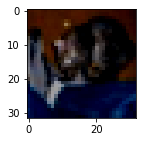

Predicted label: cat, score 6.019589900970459
Annotation label: cat


In [14]:
import numpy as np
core = Core()

compiled_model = core.compile_model(model, 'CPU')
output_tensor = compiled_model.output(0)

inference_result = compiled_model(image.numpy())[output_tensor]
pred_label = int(np.argmax(inference_result, axis=1))
pred_score = inference_result[0, pred_label]
imshow(image[0])
print(f'Predicted label: {classes[pred_label]}, score {pred_score}')
print(f'Annotation label: {classes[label[0].item()]}')

In [15]:
accuracy_metric.reset()
for (img, lbl) in tqdm(testloader):
    prediction_scores = torch.from_numpy(compiled_model(img.numpy())[output_tensor])
    accuracy_metric.update(prediction_scores, lbl)

print(f'Accuracy model on {len(testloader)} images {accuracy_metric.compute()}')

  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy model on 10000 images 0.9365000128746033


Perfect! As we can see converted model has the same level of accuracy like original.
Now, let's try to optimize model to low precision

## Optimize model using NNCF Posttrainging Quantization API


In [16]:
import nncf

# Define the transformation method. This method should
# take a data item from the data source and transform it
# into the model expected input.
def transform_fn(data_item):
    images, _ = data_item
    return images.numpy()

calibration_dataset = nncf.Dataset(testset, transform_fn)

In [17]:
quantized_model = nncf.quantize(model, calibration_dataset)

INFO:openvino.tools.pot.pipeline.pipeline:Inference Engine version:                2022.3.0-8560-1f561033fac
INFO:openvino.tools.pot.pipeline.pipeline:Model Optimizer version:                 2022.3.0-8560-1f561033fac
INFO:openvino.tools.pot.pipeline.pipeline:Post-Training Optimization Tool version: 2022.3.0-8560-1f561033fac
INFO:openvino.tools.pot.statistics.collector:Start computing statistics for algorithms : DefaultQuantization
INFO:openvino.tools.pot.statistics.collector:Computing statistics finished
INFO:openvino.tools.pot.pipeline.pipeline:Start algorithm: DefaultQuantization
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Start computing statistics for algorithm : ActivationChannelAlignment
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Computing statistics finished
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Start computing statistics for algorithms : MinMaxQuantization,FastBiasCorrection
INFO:openvino.tools.pot.algori

In [23]:
serialize(quantized_model, 'model/resnet50_int8.xml')

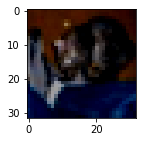

Predicted label: cat
Annotation label: cat


In [19]:
import numpy as np
core = Core()

compiled_model = core.compile_model(quantized_model, 'CPU')
output_tensor = compiled_model.outputs[0]

inference_result = compiled_model(image.numpy())[output_tensor]

imshow(image[0])
print(f'Predicted label: {classes[np.argmax(inference_result)]}')
print(f'Annotation label: {classes[label[0].item()]}')

In [20]:
accuracy_metric.reset()
for (img, lbl) in tqdm(testloader):
    prediction_scores = torch.from_numpy(compiled_model(img.numpy())[output_tensor])
    accuracy_metric.update(prediction_scores, lbl)


print(f'Accuracy model on {len(testloader)} images {accuracy_metric.compute()}')

  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy model on 10000 images 0.9355000257492065


# Compare Performance of the Original and Quantized Models

Finally, measure the inference performance of the `FP32` and `INT8` models, using [Benchmark Tool](https://docs.openvino.ai/latest/openvino_inference_engine_tools_benchmark_tool_README.html) - an inference performance measurement tool in OpenVINO.

> **Note**: For more accurate performance, it is recommended to run benchmark_app in a terminal/command prompt after closing other applications. Run `benchmark_app -m model.xml -d CPU` to benchmark async inference on CPU for one minute. Change CPU to GPU to benchmark on GPU. Run `benchmark_app --help` to see an overview of all command-line options.


In [21]:
# Inference FP32 model (OpenVINO IR)
!benchmark_app -m model/resnet50.xml -d CPU -api async

[Step 1/11] Parsing and validating input arguments
[ INFO ] Input command: /home/ea/work/notebooks_env/bin/benchmark_app -m model/resnet50.xml -d CPU -api async 
[ WARNING ]  -nstreams default value is determined automatically for a device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README. 
[Step 2/11] Loading OpenVINO
[ WARNING ] PerformanceMode was not explicitly specified in command line. Device CPU performance hint will be set to THROUGHPUT.
[ INFO ] OpenVINO:
         API version............. 2022.3.0-8560-1f561033fac
[ INFO ] Device info
         CPU
         openvino_intel_cpu_plugin version 2022.3
         Build................... 2022.3.0-8560-1f561033fac

[Step 3/11] Setting device configuration
[Step 4/11] Reading network files
[ INFO ] Read model took 50.95 ms
[Step 5/11] Resizing network to match image sizes and given batch
[ INFO ] Network batch size: 1
[Step 6/1

In [ ]:
# Inference INT8 model (OpenVINO IR)
!benchmark_app -m model/resnet50_int8.xml -d CPU -api async

[Step 1/11] Parsing and validating input arguments
[ INFO ] Input command: /home/ea/work/notebooks_env/bin/benchmark_app -m model/resnet50_int8.xml -d CPU -api async 
[ WARNING ]  -nstreams default value is determined automatically for a device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README. 
[Step 2/11] Loading OpenVINO
[ WARNING ] PerformanceMode was not explicitly specified in command line. Device CPU performance hint will be set to THROUGHPUT.
[ INFO ] OpenVINO:
         API version............. 2022.3.0-8560-1f561033fac
[ INFO ] Device info
         CPU
         openvino_intel_cpu_plugin version 2022.3
         Build................... 2022.3.0-8560-1f561033fac

[Step 3/11] Setting device configuration
[Step 4/11] Reading network files
[ INFO ] Read model took 25.15 ms
[Step 5/11] Resizing network to match image sizes and given batch
[ INFO ] Network batch size: 1
[Ste